In [1]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

import demoji

import torch
from datasets import Dataset, load_from_disk
from transformers import (
    XLMRobertaTokenizer
)


/scratch/work/truongl3/.conda_envs/bertopic-dime/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not "data" in os.listdir():
    os.mkdir("data")
    os.mkdir("data/raw")
    os.mkdir("data/processed")
os.listdir()

['conda-env.yml',
 'data',
 'data_preprocessing.ipynb',
 'hyperparameter_tuning.ipynb',
 '._.DS_Store',
 '.DS_Store',
 '.ipynb_checkpoints',
 '__init__.py']

## 1. Import raw data

Data sources: 
- [CLEF2021-CheckThat-Lab](https://gitlab.com/checkthat_lab/clef2021-checkthat-lab/-/tree/master/task1)

- [CLEF2024-CheckThat-Lab](https://gitlab.com/checkthat_lab/clef2024-checkthat-lab/-/tree/main/task1#input-data-format-tweets)




In [3]:
clef2021_path = "/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/"
clef2024_path = "/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/"

### a. CheckThat data 2021

In [4]:
## merge different language dataset into one. 
train_data = []
dev_data = []
for root, dirs, files in os.walk(clef2021_path):
    if not (
        "__MACOSX" in root or 
        root.endswith(".ipynb_checkpoints") or 
        "subtask-1b" in root
    ):
        print(root, dirs, files)
        for f in files:
            if "noclaim" not in f and f.endswith(".tsv"):
                print(f)
                df = pd.read_csv(os.path.join(root, f), sep = '\t', dtype={'tweet_id': str,})
                df["lang"] = "english" if "english" in f \
                                else ("turkish" if "turkish" in f \
                                  else "bulgarian")
                df["source"] = "Twitter"
                df.rename(columns={"claim_worthiness": "check_worthiness",}, inplace=True)
                columns = {
                    "tweet_id":"id",
                    "tweet_text":"text", 
                    "check_worthiness": "label"
                }
                df.rename(columns=columns, inplace=True)
                display(df)
                
                if f.startswith("dataset_train_"):
                    train_data.append(df)
                if f.startswith("dataset_dev_"):
                    dev_data.append(df)

keep_columns = ["id", "text", "label", "lang", "source"]
train_df = pd.concat(train_data).sort_values("id")[keep_columns].reset_index(drop=True)
dev_df = pd.concat(dev_data).sort_values("id")[keep_columns].reset_index(drop=True)

display(train_df.head(5), dev_df.head(5))


/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/ ['subtask-1a--english', 'subtask-1a--turkish', 'subtask-1a--bulgarian', 'subtask-1b--english', 'subtask-1a--arabic'] []
/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--english ['v1', '__MACOSX'] ['v1.zip']
/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--english/v1 ['.ipynb_checkpoints'] ['dataset_train_v1_english.json', 'dataset_dev_v1_english.json', 'dataset_dev_v1_english.tsv', 'dataset_train_v1_english.tsv']
dataset_dev_v1_english.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,covid-19,1237160250513522688,https://twitter.com/user/status/12371602505135...,POTUS wanted everyone to know he was in close ...,0,1,english,Twitter
1,covid-19,1237125962871037953,https://twitter.com/user/status/12371259628710...,Who would you prefer to lead our nation’s resp...,0,0,english,Twitter
2,covid-19,1237207721604235264,https://twitter.com/user/status/12372077216042...,It was a really really really really really re...,0,0,english,Twitter
3,covid-19,1237178597024108552,https://twitter.com/user/status/12371785970241...,Bald-faced #LIE. @replouiegohmert did self-qua...,0,1,english,Twitter
4,covid-19,1237049051058561024,https://twitter.com/user/status/12370490510585...,LIVE: Daily media briefing on #COVID19 with @D...,0,0,english,Twitter
...,...,...,...,...,...,...,...,...
135,covid-19,1237094362544209920,https://twitter.com/user/status/12370943625442...,This is how the Corona Virus is spreading and ...,0,0,english,Twitter
136,covid-19,1237063585580318720,https://twitter.com/user/status/12370635855803...,Markets are crashing. Tourism is dying. Travel...,0,0,english,Twitter
137,covid-19,1237159267070664705,https://twitter.com/user/status/12371592670706...,Pray for Palestine. State of Emergency. - 27 c...,0,0,english,Twitter
138,covid-19,1236972990492897281,https://twitter.com/user/status/12369729904928...,ADVISORY TO STUDENTS: Class suspensions were m...,0,0,english,Twitter


dataset_train_v1_english.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,covid-19,1234964653014384644,https://twitter.com/EricTrump/status/123496465...,Since this will never get reported by the medi...,1,1,english,Twitter
1,covid-19,1234869939720216578,https://twitter.com/RealJamesWoods/status/1234...,"Thanks, #MichaelBloomberg. Here’s a handy litt...",0,0,english,Twitter
2,covid-19,1234873136304267267,https://twitter.com/hayxsmith/status/123487313...,"Folks, when you say ""The corona virus isn't a ...",0,0,english,Twitter
3,covid-19,1235071285027147776,https://twitter.com/ipspankajnain/status/12350...,Just 1 case of Corona Virus in India and peop...,1,0,english,Twitter
4,covid-19,1234911110861594624,https://twitter.com/PressSec/status/1234911110...,President @realDonaldTrump made a commitment...,1,1,english,Twitter
...,...,...,...,...,...,...,...,...
817,covid-19,1235914080931766274,https://twitter.com/DrZweliMkhize/status/12359...,Stop spreading fake news #Coronavirus https://...,0,0,english,Twitter
818,covid-19,1235770706765451264,https://twitter.com/globaltimesnews/status/123...,It's fake! It's fake!' shout residents of a co...,1,1,english,Twitter
819,covid-19,1235973416995315712,https://twitter.com/wef/status/123597341699531...,Be Smart about #COVID19: 1️⃣ follow accurate p...,0,0,english,Twitter
820,covid-19,1235675024738185239,https://twitter.com/999saudsalman/status/12356...,"On the left: @A_AlAthbah, a Qatari puppet, att...",1,1,english,Twitter


/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--turkish ['v1'] ['.gitkeep', 'readme.md', 'v1.zip']
/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--turkish/v1 [] ['dataset_dev_v1_turkish.tsv', 'dataset_train_v1_turkish.tsv', 'dataset_train_v1_turkish_noclaim.tsv', 'dataset_dev_v1_turkish_noclaim.tsv']
dataset_dev_v1_turkish.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,miscellaneous,1095426687301500930,https://twitter.com/anyuser/status/10954266873...,CHP iktidara gelse ilk işi Türkiye'yi IMF'ye t...,-1,0,turkish,Twitter
1,miscellaneous,1147798496155754496,https://twitter.com/anyuser/status/11477984961...,HDP nin verdiği katkının 10 da 1 i kadar katkı...,-1,0,turkish,Twitter
2,miscellaneous,1100670486336471041,https://twitter.com/anyuser/status/11006704863...,Balıkesir İli 2019 Yatırım Programı açıklandı ...,-1,0,turkish,Twitter
3,miscellaneous,1135619756881514497,https://twitter.com/anyuser/status/11356197568...,@aydinbinboga Malatya istanbulun 1/20 kadar is...,-1,0,turkish,Twitter
4,miscellaneous,1083094947283329024,https://twitter.com/anyuser/status/10830949472...,OECD genelinde istihdam oranı ortalama yüzde 6...,-1,1,turkish,Twitter
...,...,...,...,...,...,...,...,...
383,miscellaneous,1102891164406108160,https://twitter.com/anyuser/status/11028911644...,Öztrak: Türkiye en yüksek enflasyona sahip 10 ...,-1,1,turkish,Twitter
384,miscellaneous,1092903937173323776,https://twitter.com/anyuser/status/10929039371...,Bu enflasyon oranıyla Türkiye dünyada en yükse...,-1,1,turkish,Twitter
385,miscellaneous,1195027871623987200,https://twitter.com/anyuser/status/11950278716...,"CHP İstanbul İl Başkanı Canan Kaftancıoğlu, At...",-1,1,turkish,Twitter
386,miscellaneous,1139478634945818624,https://twitter.com/anyuser/status/11394786349...,Seçimlere Kadar CHP İstanbul İl Başkanı Canan ...,-1,0,turkish,Twitter


dataset_train_v1_turkish.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,miscellaneous,1092742203737280512,https://twitter.com/anyuser/status/10927422037...,AK Parti’nin İstanbul Hacımaşlı köyünde bir do...,-1,1,turkish,Twitter
1,miscellaneous,1088825961494335488,https://twitter.com/anyuser/status/10888259614...,Ahlaksız Herifler... 2009 yılında İsveç'te çek...,-1,1,turkish,Twitter
2,miscellaneous,1099957637184217089,https://twitter.com/anyuser/status/10999576371...,Hacımaşlı Köyü’nde faaliyette bulunan bir domu...,-1,1,turkish,Twitter
3,miscellaneous,1139654999422599169,https://twitter.com/anyuser/status/11396549994...,Bakan Ersoy: Dünyada mavi bayrak sayısı olarak...,-1,1,turkish,Twitter
4,miscellaneous,1091734824954617858,https://twitter.com/anyuser/status/10917348249...,"Dünya genelinde 46 ülkede uygulanan ""Mavi Bayr...",-1,1,turkish,Twitter
...,...,...,...,...,...,...,...,...
1894,miscellaneous,1115216473482518531,https://twitter.com/anyuser/status/11152164734...,Putin: Türkiye ile ticaret hacmimiz 35 milyar ...,-1,1,turkish,Twitter
1895,miscellaneous,1115215325442846720,https://twitter.com/anyuser/status/11152153254...,Putin: Türkiye ile ticaret hacmimiz 35 milyar ...,-1,1,turkish,Twitter
1896,miscellaneous,1144936553208274946,https://twitter.com/anyuser/status/11449365532...,Trump'a 75 milyar dolarlık dış ticaret hacmini...,-1,0,turkish,Twitter
1897,miscellaneous,1092811608756285444,https://twitter.com/anyuser/status/10928116087...,alçak bir fırsatçılık peşine düştü. IMF'ye gid...,-1,0,turkish,Twitter


/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--bulgarian ['v1', '__MACOSX'] ['v1.zip']
/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--bulgarian/v1 [] ['dataset_dev_v1_bulgarian.tsv', 'dataset_train_v1_bulgarian.json', 'dataset_train_v1_bulgarian.tsv', 'dataset_dev_v1_bulgarian.json']
dataset_dev_v1_bulgarian.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,covid-19,1292370664708435968,https://twitter.com/user/status/12923706647084...,Това е разпределението на новите случаи на COV...,0,0,bulgarian,Twitter
1,covid-19,1246406756068143104,https://twitter.com/user/status/12464067560681...,Двама пациенти с COVID-19 починаха в УМБАЛ “Св...,1,0,bulgarian,Twitter
2,covid-19,1251595637524779010,https://twitter.com/user/status/12515956375247...,Британски учени изпитват ваксина срещу COVID-1...,1,1,bulgarian,Twitter
3,covid-19,1296462510023938048,https://twitter.com/user/status/12964625100239...,"Транспортираха тялото на жена от Каварна, почи...",1,0,bulgarian,Twitter
4,covid-19,1257918396265631744,https://twitter.com/user/status/12579183962656...,За последните 24 часа 69 са новите случаи на к...,1,0,bulgarian,Twitter
...,...,...,...,...,...,...,...,...
345,covid-19,1242006038951407616,https://twitter.com/user/status/12420060389514...,Тех Индустри България: UVC дезинфекцията – над...,1,0,bulgarian,Twitter
346,covid-19,1293992827131531264,https://twitter.com/user/status/12939928271315...,За неносене на маска в клас може да последва д...,1,0,bulgarian,Twitter
347,covid-19,1248161163503943680,https://twitter.com/user/status/12481611635039...,Втори пореден ден с близо 2000 починали с COVI...,1,0,bulgarian,Twitter
348,covid-19,1261879711745048580,https://twitter.com/user/status/12618797117450...,Учени: Слънцето помага срещу COVID-19 https://...,1,1,bulgarian,Twitter


dataset_train_v1_bulgarian.tsv


,topic_id,id,tweet_url,text,claim,label,lang,source
0,covid-19,1263039819325886467,https://twitter.com/user/status/12630398193258...,Препоръките към държавите-членки в рамките на ...,0,0,bulgarian,Twitter
1,covid-19,1283842779135827971,https://twitter.com/user/status/12838427791358...,"За тия, дет си мислят, че няма вирус https://t...",0,0,bulgarian,Twitter
2,covid-19,1256941692017614849,https://twitter.com/user/status/12569416920176...,"Отменят се част от противоепидемичните мерки, ...",1,0,bulgarian,Twitter
3,covid-19,1293089167568785409,https://twitter.com/user/status/12930891675687...,Oпазването на биоразнообразието 🦋🐅🐘🌴 остава пр...,1,0,bulgarian,Twitter
4,covid-19,1252279781372149766,https://twitter.com/user/status/12522797813721...,Кратък обзор над мерките в сградостроителствот...,0,0,bulgarian,Twitter
...,...,...,...,...,...,...,...,...
2995,covid-19,1253187951162462209,https://twitter.com/user/status/12531879511624...,"Важно! 1500 медици се ваксинираха с БЦЖ, за да...",1,1,bulgarian,Twitter
2996,covid-19,1271392641104719872,https://twitter.com/user/status/12713926411047...,Лекарка от Пирогов е заразила болни и медици в...,1,0,bulgarian,Twitter
2997,covid-19,1292239819574333441,https://twitter.com/user/status/12922398195743...,Пандемия COVID-19. 8 августа #КоронавирусВЦифр...,0,0,bulgarian,Twitter
2998,covid-19,1250723095024984064,https://twitter.com/user/status/12507230950249...,"Ако не другиго, поне да слушаме Меркел. Дори в...",1,1,bulgarian,Twitter


/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--arabic ['train'] ['.gitkeep']
/scratch/work/truongl3/DIME/clef2021-checkthat-lab/task1/data/subtask-1a--arabic/train [] ['.gitkeep', 'CT21-AR-Train-T1-v1.zip', 'CT21-AR-Train-T1-v2.zip']


,id,text,label,lang,source
0,1080354490514096128,"Dolar için söylenen bu sözler, ciddiye alınmal...",1,turkish,Twitter
1,1080373366027096065,"Mersin'de, geçen yıl 6 katı atık düzenli depol...",1,turkish,Twitter
2,1080405755625459712,"Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yı...",1,turkish,Twitter
3,1080415030577975296,1960’tan bu yana #işsizlik oranlarında en kötü...,0,turkish,Twitter
4,1080416058828341249,Türkiye’de yaşayan Suriyeli mültecilerin yurt ...,1,turkish,Twitter


,id,text,label,lang,source
0,1080606987249950720,"1.IMF'in son raporuna göre, 2017 sonunda küres...",0,turkish,Twitter
1,1080871283510964225,320 lira gelen doğalgaz faturamızla bakışıyoru...,0,turkish,Twitter
2,1080899168347017217,Hamdolsun enflasyon da Dünya üçüncüsüyüz,0,turkish,Twitter
3,1081287851889840131,2002 yılına kadar Türkiyede 1 milyar dolar ve ...,1,turkish,Twitter
4,1081633149489217536,Kamu ve Özel Sektör Toplamının GSMH oranına Ba...,1,turkish,Twitter


In [5]:
display(train_df.info(), dev_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5721 entries, 0 to 5720
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5721 non-null   object
 1   text    5721 non-null   object
 2   label   5721 non-null   int64 
 3   lang    5721 non-null   object
 4   source  5721 non-null   object
dtypes: int64(1), object(4)
memory usage: 223.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      878 non-null    object
 1   text    878 non-null    object
 2   label   878 non-null    int64 
 3   lang    878 non-null    object
 4   source  878 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.4+ KB


None

None

In [6]:
train_df["id"].sort_values(),dev_df["id"].sort_values()

(0       1080354490514096128
 1       1080373366027096065
 2       1080405755625459712
 3       1080415030577975296
 4       1080416058828341249
                ...         
 5716    1300375907169906693
 5717    1300383593991110661
 5718    1300410966191091720
 5719    1300424130706190336
 5720     332105177307947008
 Name: id, Length: 5721, dtype: object,
 0      1080606987249950720
 1      1080871283510964225
 2      1080899168347017217
 3      1081287851889840131
 4      1081633149489217536
               ...         
 873    1300097442164154368
 874    1300309469398695937
 875    1300320299079143424
 876    1300346358126333953
 877    1300351141855846401
 Name: id, Length: 878, dtype: object)

### b. CheckThat data 2024

#### i. Examine the test data:

- `_test`-data: doesn't contain labels
- `_test_gold`-data: contains labels

In [7]:
test = []
test_gold = []
for root, dirs, files in os.walk(clef2024_path):
    if not ("__MACOSX" in root or root.endswith(".ipynb_checkpoints")):
        print(root, dirs, files)
        print()
        for f in files:
            if f.endswith("_test.tsv"):
                df = pd.read_csv(os.path.join(root, f), sep = '\t', dtype={'tweet_id': str})
                test.append(df)
            if f.endswith("_test_gold.tsv"):
                df = pd.read_csv(os.path.join(root, f), sep = '\t', dtype={'tweet_id': str})
                test_gold.append(df)
test_df = pd.concat(test)
test_gold_df = pd.concat(test_gold)

display(test_df.head(10), test_gold_df.head(10))
test_df[["tweet_id","tweet_url","tweet_text"]].equals(test_gold_df[["tweet_id","tweet_url","tweet_text"]])

/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/ ['dutch', '__MACOSX', 'CT24_checkworthy_english', 'arabic', '.ipynb_checkpoints', 'english'] ['CT24_checkworthy_dutch_dev.tsv', 'CT24_checkworthy_dutch_dev-test.tsv', 'CT24_checkworthy_spanish_dev.tsv', 'CT24_checkworthy_arabic_dev.tsv', 'CT24_checkworthy_test.zip', 'CT24_checkworthy_arabic_dev-test.tsv', 'CT24_checkworthy_dutch.zip', 'CT24_checkworthy_spanish_dev-test.tsv', '.keep', 'CT24_checkworthy_dutch_train.tsv', 'CT24_checkworthy_test_gold.zip', 'CT24_checkworthy_arabic.zip', 'CT24_checkworthy_arabic_train.tsv', 'CT24_checkworthy_spanish.zip', 'CT24_checkworthy_spanish_train.tsv', 'CT24_checkworthy_english.zip']

/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/dutch [] ['CT24_checkworthy_dutch_test_gold.tsv', 'CT24_checkworthy_dutch_test.tsv']

/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/CT24_checkworthy_english [] ['CT24_checkworthy_english_dev.tsv', 'CT24_checkworthy_english_dev-test

,tweet_id,tweet_url,tweet_text,Sentence_id,Text
0,1352309940870909954,http://twitter.com/user/status/135230994087090...,De SGP in de Eerste Kamer wil de nieuwe #stiks...,NaN,NaN
1,1351166867352727556,http://twitter.com/user/status/135116686735272...,Minister Van Nieuwenhuizen biedt een Nota naar...,NaN,NaN
2,1347538141520027655,http://twitter.com/user/status/134753814152002...,"Het was verwacht, maar nu dus ook een feit: 20...",NaN,NaN
3,1369551797178818564,http://twitter.com/user/status/136955179717881...,Ik heb geen problemen met onze achterburen 'De...,NaN,NaN
4,1384166049386401793,http://twitter.com/user/status/138416604938640...,@WHO @DrTedros @GretaThunberg Dr Tedros WHO “W...,NaN,NaN
5,1349744336305590273,http://twitter.com/user/status/134974433630559...,In Duitsland ook. Kern- en kolencentrales word...,NaN,NaN
6,1388207622340419586,http://twitter.com/user/status/138820762234041...,De winnaars winnen lijken nog wat meer. Terwij...,NaN,NaN
7,1349689438939570177,http://twitter.com/user/status/134968943893957...,De Europese Commissie 🇪🇺 heeft een lijst met l...,NaN,NaN
8,1348640500962783232,http://twitter.com/user/status/134864050096278...,"Ondanks #Lockdownnl, ondanks overvol land met ...",NaN,NaN
9,1345305940346728449,http://twitter.com/user/status/134530594034672...,@gertjansegers @PieterHeerma Resultaat: #liege...,NaN,NaN


,tweet_id,tweet_url,tweet_text,class_label,Sentence_id,Text
0,1352309940870909954,http://twitter.com/user/status/135230994087090...,De SGP in de Eerste Kamer wil de nieuwe #stiks...,Yes,NaN,NaN
1,1351166867352727556,http://twitter.com/user/status/135116686735272...,Minister Van Nieuwenhuizen biedt een Nota naar...,Yes,NaN,NaN
2,1347538141520027655,http://twitter.com/user/status/134753814152002...,"Het was verwacht, maar nu dus ook een feit: 20...",Yes,NaN,NaN
3,1369551797178818564,http://twitter.com/user/status/136955179717881...,Ik heb geen problemen met onze achterburen 'De...,Yes,NaN,NaN
4,1384166049386401793,http://twitter.com/user/status/138416604938640...,@WHO @DrTedros @GretaThunberg Dr Tedros WHO “W...,Yes,NaN,NaN
5,1349744336305590273,http://twitter.com/user/status/134974433630559...,In Duitsland ook. Kern- en kolencentrales word...,Yes,NaN,NaN
6,1388207622340419586,http://twitter.com/user/status/138820762234041...,De winnaars winnen lijken nog wat meer. Terwij...,Yes,NaN,NaN
7,1349689438939570177,http://twitter.com/user/status/134968943893957...,De Europese Commissie 🇪🇺 heeft een lijst met l...,Yes,NaN,NaN
8,1348640500962783232,http://twitter.com/user/status/134864050096278...,"Ondanks #Lockdownnl, ondanks overvol land met ...",Yes,NaN,NaN
9,1345305940346728449,http://twitter.com/user/status/134530594034672...,@gertjansegers @PieterHeerma Resultaat: #liege...,Yes,NaN,NaN


True

In [8]:
test_df["tweet_id"].sort_values(),test_gold_df["tweet_id"].sort_values()

(900    1344951697026805760
 9      1345305940346728449
 2      1347538141520027655
 931    1348051178416959489
 19     1348208236965617665
               ...         
 336                    NaN
 337                    NaN
 338                    NaN
 339                    NaN
 340                    NaN
 Name: tweet_id, Length: 1951, dtype: object,
 900    1344951697026805760
 9      1345305940346728449
 2      1347538141520027655
 931    1348051178416959489
 19     1348208236965617665
               ...         
 336                    NaN
 337                    NaN
 338                    NaN
 339                    NaN
 340                    NaN
 Name: tweet_id, Length: 1951, dtype: object)

#### ii. Read and merge the train-dev-test data:

- From [CLEF2024-CheckThat-Lab](https://gitlab.com/checkthat_lab/clef2024-checkthat-lab/-/tree/main/task1#input-data-format-tweets) README:

    + Input Data Format (Tweets)

        For **Arabic**, **Spanish** and **Dutch** we use the same data format in the train, dev and dev-test files. Each file is TAB seperated (TSV file) containing the tweets and their labels. The text encoding is UTF-8. Each row in the file has the following format:
        
        `tweet_id <TAB> tweet_url <TAB> tweet_text <TAB> class_label`
        
        Where: <br>
        * tweet_id: Tweet ID for a given tweet given by Twitter <br/>
        * tweet_url: URL to the given tweet <br/>
        * tweet_text: content of the tweet <br/>
        * class_label: *Yes* and *No*
     
    + Input Data Format (Political debates)
 
        For **English** we use the same data format in the train, dev and dev-test files. Each file is TAB seperated (TSV file) containing the sentences and their labels. The text encoding is UTF-8. Each row in the file has the following format:
        
        `Sentence_id <TAB> Text <TAB> class_label`

        Where: <br>
        * Sentence_id: sentence id for a given political debate <br/>
        * Text: sentence's text <br/>
        * class_label: *Yes* and *No*

    

In [9]:
train = []
dev = []
test = []
for root, dirs, files in os.walk(clef2024_path):
    if not ("__MACOSX" in root or root.endswith(".ipynb_checkpoints")):
        print(root, dirs, files)
        for f in files:
            if not (
                f.endswith("_test.tsv") or 
                f.endswith("_test_gold.tsv") or 
                f == '.keep' or 
                '.zip' in f 
            ):
                df = pd.read_csv(
                    os.path.join(root, f), 
                    sep = '\t', 
                    dtype={'tweet_id': str, 'Sentence_id': str}
                )
                
                df["lang"] = "english" if "english" in f else ("dutch" if "dutch" in f else ("spanish" if "spanish" in f else("arabic")))
                df["source"] = "Twitter" if "tweet_id" in df.columns else "Political debates"

                columns = {
                    "tweet_text": "text", 
                    "Text": "text", 
                    "class_label":"label",
                    "tweet_id":"id",
                    "Sentence_id":"id"
                }
                
                df.rename(columns = columns, inplace=True)
                
                print("Files: \t", f)
                display(df)
                print()
                if f.endswith("_dev-test.tsv"):
                    test.append(df)
                if f.endswith("_dev.tsv"):
                    dev.append(df)
                if f.endswith("_train.tsv"):
                    train.append(df)

keep_columns = ["id", "text", "label", "lang", "source"]
train_df_ = pd.concat(train)[keep_columns].reset_index(drop=True)
dev_df_ = pd.concat(dev)[keep_columns].reset_index(drop=True)
test_df_ = pd.concat(test)[keep_columns].reset_index(drop=True)

/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/ ['dutch', '__MACOSX', 'CT24_checkworthy_english', 'arabic', '.ipynb_checkpoints', 'english'] ['CT24_checkworthy_dutch_dev.tsv', 'CT24_checkworthy_dutch_dev-test.tsv', 'CT24_checkworthy_spanish_dev.tsv', 'CT24_checkworthy_arabic_dev.tsv', 'CT24_checkworthy_test.zip', 'CT24_checkworthy_arabic_dev-test.tsv', 'CT24_checkworthy_dutch.zip', 'CT24_checkworthy_spanish_dev-test.tsv', '.keep', 'CT24_checkworthy_dutch_train.tsv', 'CT24_checkworthy_test_gold.zip', 'CT24_checkworthy_arabic.zip', 'CT24_checkworthy_arabic_train.tsv', 'CT24_checkworthy_spanish.zip', 'CT24_checkworthy_spanish_train.tsv', 'CT24_checkworthy_english.zip']
Files: 	 CT24_checkworthy_dutch_dev.tsv


,id,tweet_url,text,label,lang,source
0,1254745849286004736,http://twitter.com/user/status/125474584928600...,Nieuws over met #COVID19 besmette nertsenbedri...,No,dutch,Twitter
1,1242150300179476480,http://twitter.com/user/status/124215030017947...,Doe eens iets aan die fotografen die de hele t...,No,dutch,Twitter
2,1240592654272008195,http://twitter.com/user/status/124059265427200...,@HildeDemarre @ChildFocusNL Oh dat doet deugd....,No,dutch,Twitter
3,1246779927791312897,http://twitter.com/user/status/124677992779131...,Nu live op radio en Facebook Perry Zuidam live...,No,dutch,Twitter
4,1248206835833847808,http://twitter.com/user/status/124820683583384...,Ik zie zomaar TWEE vliegtuigen in de overigens...,No,dutch,Twitter
...,...,...,...,...,...,...
247,1293778089621762053,http://twitter.com/user/status/129377808962176...,@jndkgrf Dit zegt zoveel over het gehele belei...,No,dutch,Twitter
248,1304448692565479425,http://twitter.com/user/status/130444869256547...,‘Men heeft ook weinig geleerd van de beginfase...,Yes,dutch,Twitter
249,1272636566230482944,http://twitter.com/user/status/127263656623048...,Net zoals het rivm zei dat de kans minimaal is...,Yes,dutch,Twitter
250,1285266984796594177,http://twitter.com/user/status/128526698479659...,Versterk je immuunsysteem en verhoog je weerst...,Yes,dutch,Twitter



Files: 	 CT24_checkworthy_dutch_dev-test.tsv


,id,tweet_url,text,label,lang,source
0,1256120472875524096,http://twitter.com/user/status/125612047287552...,"Ik merk op da ""kleinere"" supermark en me voo...",Yes,dutch,Twitter
1,1256154134027350019,http://twitter.com/user/status/125615413402735...,Vanaf maandag 4 mei dragen we een mondmasker o...,No,dutch,Twitter
2,1256253220239872000,http://twitter.com/user/status/125625322023987...,@evaverhoevenph1 Er is bij mijn we en geen enk...,Yes,dutch,Twitter
3,1256305038139576326,http://twitter.com/user/status/125630503813957...,De #Volkskran 29 april: In #Nederland zijn b...,No,dutch,Twitter
4,1256487670311682048,http://twitter.com/user/status/125648767031168...,Hoe ro en ongewens de si ua ie waarin we me ...,No,dutch,Twitter
...,...,...,...,...,...,...
661,1342524082621964288,http://twitter.com/user/status/134252408262196...,@Sanspareille @UWVnl @RTLZ Veel werkgevers zij...,No,dutch,Twitter
662,1343854761871867904,http://twitter.com/user/status/134385476187186...,#Lagerhuis #VS s em in me #coronacheque van ...,Yes,dutch,Twitter
663,1344553798610640896,http://twitter.com/user/status/134455379861064...,@PGoldschmeding En wa be ref he s ijgende e...,No,dutch,Twitter
664,1344555052350976000,http://twitter.com/user/status/134455505235097...,"Gro e, illegale echnorave Hoofddorp: ’Telefoo...",No,dutch,Twitter



Files: 	 CT24_checkworthy_spanish_dev.tsv


,id,tweet_url,text,label,lang,source
0,1468170499406639107,https://twitter.com/user/status/14681704994066...,"1995, Bajo el orden de Israel, el 80% de la po...",Yes,spanish,Twitter
1,1456714073710768129,https://twitter.com/user/status/14567140737107...,El @psoe ha estado trabajando desde el comienz...,No,spanish,Twitter
2,1448983098813734916,https://twitter.com/user/status/14489830988137...,Fortalecer el diálogo es fundamental para impu...,No,spanish,Twitter
3,1465828278900563969,https://twitter.com/user/status/14658282789005...,1 de diciembre y un objetivo compartido: Poner...,No,spanish,Twitter
4,1436412790751830018,https://twitter.com/user/status/14364127907518...,Por ellos: Francisco José Alcaraz convoca una ...,No,spanish,Twitter
...,...,...,...,...,...,...
4995,1454818788126380037,https://twitter.com/user/status/14548187881263...,"Para ser grande, se entero: nada tuyo exageres...",No,spanish,Twitter
4996,1464547666487132170,https://twitter.com/user/status/14645476664871...,Las políticas de @PSOE son las de la mayoría s...,No,spanish,Twitter
4997,1458749622592155648,https://twitter.com/user/status/14587496225921...,Un gobierno incompetente y que engaña a los es...,Yes,spanish,Twitter
4998,1455926135494217729,https://twitter.com/user/status/14559261354942...,Algunas de nuestras enmiendas a los #PGE2022: ...,No,spanish,Twitter



Files: 	 CT24_checkworthy_arabic_dev.tsv


,id,tweet_url,text,label,lang,source
0,1345895983629086720,https://twitter.com/alaraby_ar/status/13458959...,"د. سعد الفقيه @saadalfagih على قناة الحوار: ""ا...",Yes,arabic,Twitter
1,1345983974712238080,https://twitter.com/alaraby_ar/status/13459839...,ما الذي تريده قطر من القمة؟ https://t.co/UO9do...,No,arabic,Twitter
2,1346084576305836032,https://twitter.com/alaraby_ar/status/13460845...,أختصار قطر تريد فتح الأجواء والحدود دون شروط ف...,No,arabic,Twitter
3,1346144307309375495,https://twitter.com/alaraby_ar/status/13461443...,يقال أن بعد ساعات سوف يصدر إعلان من #السعودية ...,Yes,arabic,Twitter
4,1346148004089225222,https://twitter.com/alaraby_ar/status/13461480...,طموحات الرباعي العربي تتلخص في ترسيخ الأمن وال...,No,arabic,Twitter
...,...,...,...,...,...,...
1088,1367536456210796545,http://twitter.com/user/status/136753645621079...,مصر تخطط لوضع رسوم على لقاح كوفيد١٩ مما يزيد م...,Yes,arabic,Twitter
1089,1367536546845491205,http://twitter.com/user/status/136753654684549...,@prof_fraih بالضبط دكتورنا الفاضل نشر الثقافه ...,No,arabic,Twitter
1090,1367536623882297347,http://twitter.com/user/status/136753662388229...,الحمد لله على لطفه وتيسيره تم في هذا اليوم تلق...,No,arabic,Twitter
1091,1367536766778036224,http://twitter.com/user/status/136753676677803...,السعودية تتبرع لقاحات كورونا لسودان وغانا وكوت...,No,arabic,Twitter



Files: 	 CT24_checkworthy_arabic_dev-test.tsv


,id,tweet_url,text,label,lang,source
0,1384982948093513728,http://twitter.com/user/status/138498294809351...,تم إعطاء أكثر من 950 مليون لقاح كوفيد حول العا...,Yes,arabic,Twitter
1,1396570173415563274,http://twitter.com/user/status/139657017341556...,الشك.. اقطعه باليقين.. الطمع.. اهزمه بالقناعة....,No,arabic,Twitter
2,1478318628076466177,http://twitter.com/user/status/147831862807646...,نرصد حالياً ارتفاعا في عدد الإصابات بفيروس كور...,Yes,arabic,Twitter
3,1350517273765801984,http://twitter.com/user/status/135051727376580...,فيديو متداول عالميًا يجاوب لصلب سؤال أصحاب نظر...,Yes,arabic,Twitter
4,1478363461184901128,http://twitter.com/user/status/147836346118490...,استكمال الحصول على جرعات اللقاح؛ حماية للأسرة ...,No,arabic,Twitter
...,...,...,...,...,...,...
495,1521790164028346370,http://twitter.com/user/status/152179016402834...,مدير موديرنا : صممنا اللقاح في يومين علي الكوم...,Yes,arabic,Twitter
496,1490761848106405889,http://twitter.com/user/status/149076184810640...,سلامة وصحة أطفالنا برقبة وزير الصحة..لا لتطعيم...,No,arabic,Twitter
497,1525626269471322113,http://twitter.com/user/status/152562626947132...,يجتمع ١٧٠٠٠ دكتور لإيقاف لقاحات كوفيد. د. روبر...,Yes,arabic,Twitter
498,1516823927514968077,http://twitter.com/user/status/151682392751496...,بين 1929-1972 قامت #امريكا بتجربة لا إنسانية ل...,Yes,arabic,Twitter



Files: 	 CT24_checkworthy_spanish_dev-test.tsv


,id,tweet_url,text,label,lang,source
0,1579540827319447556,https://twitter.com/twitter/status/15795408273...,En @sanidadgob con las ministras de Sanidad @C...,No,spanish,Twitter
1,118034,NaN,"Gestión bajada de impuestos, reducción de trab...",No,spanish,Twitter
2,112393,NaN,Le tengo que decir aunque ya se lo dije la últ...,No,spanish,Twitter
3,1578349684007260162,https://twitter.com/twitter/status/15783496840...,"🔵 He recibido, hoy en el @mapagob, al nuevo di...",No,spanish,Twitter
4,64522,NaN,El sistema es tan potente que tiene unos mecan...,No,spanish,Twitter
...,...,...,...,...,...,...
4995,85168,NaN,"No, no, no, no consigo nada.",No,spanish,Twitter
4996,101936,NaN,"Primero con mi Augé, con Iberia y también con ...",No,spanish,Twitter
4997,1577914395010764800,https://twitter.com/twitter/status/15779143950...,El cas de les restes del President Sunyol és u...,No,spanish,Twitter
4998,1579255567297949696,https://twitter.com/twitter/status/15792555672...,"@acuario_venus En política, hay batallas q aun...",No,spanish,Twitter



Files: 	 CT24_checkworthy_dutch_train.tsv


,id,tweet_url,text,label,lang,source
0,1240603314980392966,http://twitter.com/user/status/124060331498039...,"#SamenTegenCorona: applaus voor zorghelden, hu...",No,dutch,Twitter
1,1238094774453833730,http://twitter.com/user/status/123809477445383...,Kabinet ondersteunt ondernemer in Corona-crisi...,No,dutch,Twitter
2,1238154603583156225,http://twitter.com/user/status/123815460358315...,Heropening van het @airbornemuseum in #Oosterb...,No,dutch,Twitter
3,1239152526026518534,http://twitter.com/user/status/123915252602651...,Aantal restaurants in #groningen nu op slot. #...,Yes,dutch,Twitter
4,1244341963480076290,http://twitter.com/user/status/124434196348007...,Nederland heeft het niet in de hand. Onbetrouw...,Yes,dutch,Twitter
...,...,...,...,...,...,...
990,1253322004544892937,http://twitter.com/user/status/125332200454489...,Door Covid-19 zetten organisaties massaal in o...,No,dutch,Twitter
991,1240614429127041024,http://twitter.com/user/status/124061442912704...,Ons crisisteam #Corona gaat locaties af om onz...,No,dutch,Twitter
992,1305431406647087106,http://twitter.com/user/status/130543140664708...,@demandieallesk2 @aajbrouwer @volkskrant https...,Yes,dutch,Twitter
993,1268546629935804418,http://twitter.com/user/status/126854662993580...,Vandaag op onze website: nieuwe versies van co...,No,dutch,Twitter



Files: 	 CT24_checkworthy_arabic_train.tsv


,id,tweet_url,text,label,lang,source
0,1221949644554588160,https://twitter.com/user/status/12219496445545...,وأي خيانة أكبر من خيانة الدين ،، الوطن ،، الهو...,No,arabic,Twitter
1,1222030473385345028,https://twitter.com/user/status/12220304733853...,صباح الخير على فلسطين وقدسها وشعبها ومهجرينها ...,No,arabic,Twitter
2,1222035929105338368,https://twitter.com/user/status/12220359291053...,ذنبگ أنگ جميله گ يوسف وخانگ العالم گ أاخواته 💔...,No,arabic,Twitter
3,1222048121145962496,https://twitter.com/user/status/12220481211459...,لا يلزمك ان تكون فلسطينياً لتحب فلسطين، حُبها ...,No,arabic,Twitter
4,1222053294266372096,https://twitter.com/user/status/12220532942663...,#مناصرون رحل البروفسور زيك فريد فوغل . رئيس قس...,No,arabic,Twitter
...,...,...,...,...,...,...
7328,1366469668089827332,http://twitter.com/user/status/136646966808982...,وزير الصحة: ربط قبول المشاركين في موسم #الحج ب...,No,arabic,Twitter
7329,1296531196462202882,http://twitter.com/user/status/129653119646220...,#روسيا تخطط لتصدير اللقاح ضد #كورونا في نهاية ...,Yes,arabic,Twitter
7330,1293180035663241218,http://twitter.com/user/status/129318003566324...,"#روسيا تطلق اسم ""سبوتنيك 5"" على أول لقاح فى ال...",No,arabic,Twitter
7331,1242563204661809159,http://twitter.com/user/status/124256320466180...,#عاجل برئاسة #خادم_الحرمين_الشريفين .. عقد الق...,No,arabic,Twitter



Files: 	 CT24_checkworthy_spanish_train.tsv


,id,tweet_url,text,label,lang,source
0,1192517071348699136,https://twitter.com/user/status/11925170713486...,"📅 Mañana, viernes, no puedes perderte el gran ...",No,spanish,Twitter
1,1220987059701190656,https://twitter.com/user/status/12209870597011...,"🔴 DIRECTO | Reyes Maroto: ""Si nos centramos en...",No,spanish,Twitter
2,1226786513226280961,https://twitter.com/user/status/12267865132262...,@JonInarritu @EHBilduCongreso 🔴🎙️ @JonInarritu...,No,spanish,Twitter
3,1217566329823252481,https://twitter.com/user/status/12175663298232...,@tve_tve vuelve a quedar en evidencia. Desplaz...,Yes,spanish,Twitter
4,1172059020095610881,https://twitter.com/user/status/11720590200956...,El nuevo curso escolar en #Andalucía comienza ...,Yes,spanish,Twitter
...,...,...,...,...,...,...
19943,189627,NaN,"Cuando Inés Arrimadas le contó, le dijo a Pabl...",Yes,spanish,Twitter
19944,222938,NaN,"Al menos yo ser presidente, no tocar ese asunt...",No,spanish,Twitter
19945,207681,NaN,En memoria de quienes durante años nos han tra...,No,spanish,Twitter
19946,330393,NaN,Enrique López Muchas gracias por estar con nos...,No,spanish,Twitter



/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/dutch [] ['CT24_checkworthy_dutch_test_gold.tsv', 'CT24_checkworthy_dutch_test.tsv']
/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/CT24_checkworthy_english [] ['CT24_checkworthy_english_dev.tsv', 'CT24_checkworthy_english_dev-test.tsv', 'CT24_checkworthy_english_train.tsv']
Files: 	 CT24_checkworthy_english_dev.tsv


,id,text,label,lang,source
0,26,"You know, I saw a movie - ""Crocodile Dundee.""",No,english,Political debates
1,80,We're consuming 50 percent of the world's coca...,Yes,english,Political debates
2,129,That answer was about as clear as Boston harbor.,No,english,Political debates
3,131,Let me help the governor.,No,english,Political debates
4,172,We've run up more debt in the last eight years...,Yes,english,Political debates
...,...,...,...,...,...
1027,28958,He has promised a trillion dollars out of the ...,Yes,english,Political debates
1028,28965,(LAUGHTER) I -- there's an old high school deb...,No,english,Political debates
1029,29011,"Well, can I answer that?",No,english,Political debates
1030,29060,I look forward to the final weeks of this camp...,No,english,Political debates



Files: 	 CT24_checkworthy_english_dev-test.tsv


,id,text,label,lang,source
0,37436,He's been a professor for a long time at a gre...,No,english,Political debates
1,37440,There's no way they would give it up.,No,english,Political debates
2,37463,They're able to charge women more for the same...,Yes,english,Political debates
3,37470,"As far as a say is concerned, the people alrea...",No,english,Political debates
4,37504,I am the Democratic Party right now.,No,english,Political debates
...,...,...,...,...,...
313,40950,We had the best Black unemployment numbers in ...,Yes,english,Political debates
314,40954,Success is going to bring us together.,No,english,Political debates
315,40960,Your 401K's will go to hell and it'll be a ver...,No,english,Political debates
316,40971,We're going to choose to move forward because ...,No,english,Political debates



Files: 	 CT24_checkworthy_english_train.tsv


,id,text,label,lang,source
0,30313,And so I know that this campaign has caused so...,No,english,Political debates
1,19099,"Now, let's balance the budget and protect Medi...",No,english,Political debates
2,33964,I'd like to mention one thing.,No,english,Political debates
3,16871,I must remind him the Democrats have controlle...,Yes,english,Political debates
4,13150,And to take a chance uh - now be - and not mak...,No,english,Political debates
...,...,...,...,...,...
22496,29631,"It would be squandered, too, believe me.",No,english,Political debates
22497,7136,We're not allowed to vote on it.,Yes,english,Political debates
22498,181,More Americans at work today than any time in ...,Yes,english,Political debates
22499,12863,We indicated at that time that we were not goi...,Yes,english,Political debates



/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/arabic [] ['CT24_checkworthy_arabic_test_gold.tsv', 'CT24_checkworthy_arabic_test.tsv']
/scratch/work/truongl3/DIME/clef2024-checkthat-lab/task1/data/english [] ['CT24_checkworthy_english_test_gold.tsv', 'CT24_checkworthy_english_test.tsv']


In [10]:
display(train_df_.sort_values("id").head(5), dev_df_.sort_values("id").head(5), test_df_.sort_values("id").head(5))

,id,text,label,lang,source
6072,1.24105E+18,#وزارة_الصحة تُعلن تسجيل 70 حالة إصابة جديدة ب...,No,arabic,Twitter
8108,1.29317E+18,‌#شاهد.. الرئيس الروسي🇷🇺 فلاديمير #بوتين يعلن ...,No,arabic,Twitter
6518,1.29522E+18,"خبراء ينصحون بأخذ لقاح ""متوفر"" حاليا لتخفيف أز...",Yes,arabic,Twitter
6581,1.29779E+18,السفير الصيني بـ #الرياض: تم استخدام لقاح #كور...,No,arabic,Twitter
49199,10002,This used to be a bipartisan issue.,No,english,Political debates


,id,text,label,lang,source
4427,"1,44477E+18",👉 ⁦@vox_es⁩ critica el “disparate” de la inclu...,No,spanish,Twitter
3879,"1,45043E+18",Un año más #MeSumoAlRosa para apoyar el #DíaMu...,No,spanish,Twitter
6812,10040,"Thank you Kerry for your question, it's an imp...",No,english,Political debates
6813,10043,And today there's a memorial service for one o...,No,english,Political debates
6814,10060,"Syria -- Syria's not just a tragedy of 30,000 ...",Yes,english,Political debates


,id,text,label,lang,source
3290,"1,57729E+18",No estamos contentas con el hecho de que el PS...,Yes,spanish,Twitter
3580,"1,5777E+18","Frente al reparto partidista, neutralidad y co...",No,spanish,Twitter
1503,"1,57811E+18",@delaordenc 😘😘😘,No,spanish,Twitter
1524,"1,57835E+18",@Geryon001 @InformacionK https://t.co/0j8qWa4NGa,No,spanish,Twitter
4717,100000,Y saben por qué?,No,spanish,Twitter


In [11]:
display(train_df_.info(), dev_df_.info(), test_df_.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50777 entries, 0 to 50776
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50777 non-null  object
 1   text    50777 non-null  object
 2   label   50777 non-null  object
 3   lang    50777 non-null  object
 4   source  50777 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7377 non-null   object
 1   text    7377 non-null   object
 2   label   7377 non-null   object
 3   lang    7377 non-null   object
 4   source  7377 non-null   object
dtypes: object(5)
memory usage: 288.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6484 entries, 0 to 6483
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6484 non-

None

None

None

### c. Merge CheckThat data 2021 + 2024

- Merge

- Examine distribution

In [12]:
train_df = pd.concat([train_df, train_df_]).reset_index(drop=True)
dev_df = pd.concat([dev_df, dev_df_]).reset_index(drop=True)
test_df = test_df_.reset_index(drop=True)

display(train_df.lang.value_counts(), dev_df.lang.value_counts(), test_df.lang.value_counts())

lang
english      23323
spanish      19948
arabic        7333
bulgarian     3000
turkish       1899
dutch          995
Name: count, dtype: int64

lang
spanish      5000
english      1172
arabic       1093
turkish       388
bulgarian     350
dutch         252
Name: count, dtype: int64

lang
spanish    5000
dutch       666
arabic      500
english     318
Name: count, dtype: int64

In [13]:
train_df["train_dev_test_split"] = "train"
dev_df["train_dev_test_split"] = "dev"
test_df["train_dev_test_split"] = "test"

df = pd.concat([train_df, dev_df, test_df]).reset_index(drop=True)

In [14]:
df.groupby(["train_dev_test_split", "lang"]).count()[["text"]]#.plot.bar(stacked=True)

text
train_dev_test_split lang            
dev                  arabic      1093
                     bulgarian    350
                     dutch        252
                     english     1172
                     spanish     5000
                     turkish      388
test                 arabic       500
                     dutch        666
                     english      318
                     spanish     5000
train                arabic      7333
                     bulgarian   3000
                     dutch        995
                     english    23323
                     spanish    19948
                     turkish     1899

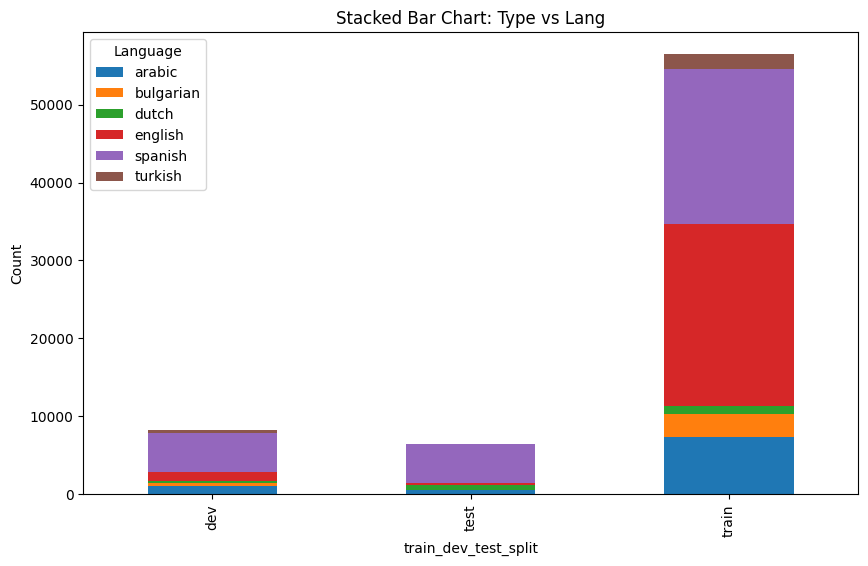

In [15]:
grouped_df = df.groupby(["train_dev_test_split", "lang"])["text"].count().unstack("lang")

grouped_df.plot.bar(stacked=True, figsize=(10, 6))
plt.xlabel("train_dev_test_split")
plt.ylabel("Count")
plt.title("Stacked Bar Chart: Type vs Lang")
plt.legend(title="Language")
plt.show()


- The language distribution is very unbalanced especially for dev and test set. In case of the test set, there are languages missing because the CheckThat-data from 2021 don't have a test set. Thus, it's better to merge all the data and create a new train-dev-test splits.
- There are also duplicated Ids and text
- Political debates data has "yes/no" labels and those should be changed to binary

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71237 entries, 0 to 71236
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    71237 non-null  object
 1   text                  71237 non-null  object
 2   label                 71237 non-null  object
 3   lang                  71237 non-null  object
 4   source                71237 non-null  object
 5   train_dev_test_split  71237 non-null  object
dtypes: object(6)
memory usage: 3.3+ MB


In [17]:
display(
    df.loc[df["id"].duplicated(keep=False)].sort_values("id"),
    df.loc[df["text"].duplicated(keep=False)].sort_values("text")
)

,id,text,label,lang,source,train_dev_test_split
42496,10121,And her son had been shot through the head.,No,english,Political debates,train
29701,10121,"Como diría el otro, porque precisamente en una...",No,spanish,Twitter,train
33674,10145,"Bueno, esperemos que todo esto mejore.",No,spanish,Twitter,train
44081,10145,But let me mention another thing.,No,english,Political debates,train
27449,10203,"Ayer, dentro del lamentable espectáculo en el ...",No,spanish,Twitter,train
...,...,...,...,...,...,...
49848,9945,Let me mention something else the president said.,No,english,Political debates,train
47672,9964,Have you looked at your pension?,No,english,Political debates,train
31288,9964,Donde parecía que el consenso se nos escapaba.,No,spanish,Twitter,train
64186,9984,I do want to make sure that -- I do want to ma...,No,english,Political debates,dev


,id,text,label,lang,source,train_dev_test_split
56770,1140096436299681792,"""İhracatın ithalatı karşılama oranında yüzde 9...",1,turkish,Twitter,dev
1292,1140719944654569477,"""İhracatın ithalatı karşılama oranında yüzde 9...",1,turkish,Twitter,train
772,1115211241579065345,#Erdoğan: Ticaret hacmimizde yüzde 15'lik artı...,0,turkish,Twitter,train
773,1115211241579065345,#Erdoğan: Ticaret hacmimizde yüzde 15'lik artı...,0,turkish,Twitter,train
36637,24520,#NAME?,No,english,Political debates,train
...,...,...,...,...,...,...
81,1084449168125583360,🎙 CHP Bursa Milletvekili Orhan Sarıbal @orhans...,1,turkish,Twitter,train
80,1084449168125583360,🎙 CHP Bursa Milletvekili Orhan Sarıbal @orhans...,1,turkish,Twitter,train
79,1084449168125583360,🎙 CHP Bursa Milletvekili Orhan Sarıbal @orhans...,1,turkish,Twitter,train
56515,1084568681403826178,🎙 CHP Genel Başkan Yardımcısı ve Parti Sözcüsü...,0,turkish,Twitter,dev


In [18]:
df = df.drop_duplicates("text")
df["label"] = df["label"].replace(to_replace = {"No": 0, "Yes": 1})
df["label"].value_counts()

/tmp/ipykernel_1255290/538964454.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace(to_replace = {"No": 0, "Yes": 1})


label
0    55276
1    15581
Name: count, dtype: int64

In [19]:
df['id'].sort_values().head(50)

61803            1,44477E+18
61255            1,45043E+18
68043            1,57729E+18
68333             1,5777E+18
66256            1,57811E+18
66277            1,57835E+18
11793            1.24105E+18
13829            1.29317E+18
12239            1.29522E+18
12302            1.29779E+18
69470                 100000
54920                  10002
66138                 100027
70565                 100069
27325                 100088
69261                 100091
33834                 100099
68757                 100109
25177                 100128
37378                  10017
35365                  10018
42226                  10019
41001                  10020
19174    1002085966822232064
38112                  10021
67859                 100215
26939                 100218
42462                  10022
46902                  10023
41523                  10024
40717                  10025
35501                  10026
65953                 100260
50686                  10027
34439         

In [20]:
df.to_parquet("./data/raw/checkthat21_24.parquet.gzip", index=False)

## 2. Preprocess tweet texts

In [21]:
## Preprocessing text:

###
# Smaller preprocessing modules:
# - Remove emoji
# - Remove hashtag #
# - Remove mention @
# - Remove URL
###
def give_emoji_free_text(text):
    # https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    return demoji.replace(text, '')

def remove_url(text):
    pattern = re.compile("\shttps*\S+")
    return re.sub(pattern, "", text)
    
def remove_hashtag_char(text):
    pattern = re.compile("\s#")
    return re.sub(pattern, " ", text)
    
def remove_mention_char(text):
    pattern = re.compile("\s@")
    return re.sub(pattern, " ", text)

###
# Main preprocessing module
###

def preprocess(text):
    processed_text = give_emoji_free_text(text)
    processed_text = remove_url(processed_text)
    # processed_text = remove_hashtag_char(processed_text)
    # processed_text = remove_mention_char(processed_text)
    return processed_text


In [22]:
df = pd.read_parquet("./data/raw/checkthat21_24.parquet.gzip")
df["processed_text"] = df["text"].apply(preprocess)

In [23]:
df.loc[df["source"] == "Twitter"].head(10)[["text", "processed_text"]].values

array([['Dolar için söylenen bu sözler, ciddiye alınmalı. "Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yılında 7.5 TL olacağını öngördüğünü söyledi. Eğilmez, yeni yılda IMF\'nin dolar kuru beklentisinin ise 10.21 TL olduğunu belirtti."',
        'Dolar için söylenen bu sözler, ciddiye alınmalı. "Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yılında 7.5 TL olacağını öngördüğünü söyledi. Eğilmez, yeni yılda IMF\'nin dolar kuru beklentisinin ise 10.21 TL olduğunu belirtti."'],
       ["Mersin'de, geçen yıl 6 katı atık düzenli depolama merkezinde 594 bin 972 ton atık bertaraf edilirken, 47 bin 812 megavat elektrik üretildi. https://t.co/BZYjnUcqX9",
        "Mersin'de, geçen yıl 6 katı atık düzenli depolama merkezinde 594 bin 972 ton atık bertaraf edilirken, 47 bin 812 megavat elektrik üretildi."],
       ['Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yılında 7.5 TL olacağını öngördüğünü söyledi.',
        'Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yılında 7.5 TL olacağını öngördüğünü söyle

In [24]:
df["id"].sort_values().head(50)

61440            1,44477E+18
60892            1,45043E+18
67668            1,57729E+18
67958             1,5777E+18
65881            1,57811E+18
65902            1,57835E+18
11743            1.24105E+18
13779            1.29317E+18
12189            1.29522E+18
12252            1.29779E+18
69094                 100000
54591                  10002
65763                 100027
70188                 100069
27220                 100088
68885                 100091
33593                 100099
68381                 100109
25121                 100128
37134                  10017
35122                  10018
41968                  10019
40749                  10020
19124    1002085966822232064
37867                  10021
67484                 100215
26847                 100218
42204                  10022
46629                  10023
41266                  10024
40465                  10025
35258                  10026
65578                 100260
50394                  10027
34197         

In [25]:
df.to_parquet("./data/processed/checkthat21_24.parquet.gzip", index=False)

## 3. Create train-val-test datasets

In [26]:
df = pd.read_parquet("./data/processed/checkthat21_24.parquet.gzip")
df.reset_index(drop=True, inplace=True)
df.head(5)

,id,text,label,lang,source,train_dev_test_split,processed_text
0,1080354490514096128,"Dolar için söylenen bu sözler, ciddiye alınmal...",1,turkish,Twitter,train,"Dolar için söylenen bu sözler, ciddiye alınmal..."
1,1080373366027096065,"Mersin'de, geçen yıl 6 katı atık düzenli depol...",1,turkish,Twitter,train,"Mersin'de, geçen yıl 6 katı atık düzenli depol..."
2,1080405755625459712,"Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yı...",1,turkish,Twitter,train,"Ekonomist Mahfi Eğilmez, dolar kurunun 2019 yı..."
3,1080415030577975296,1960’tan bu yana #işsizlik oranlarında en kötü...,0,turkish,Twitter,train,1960’tan bu yana #işsizlik oranlarında en kötü...
4,1080416058828341249,Türkiye’de yaşayan Suriyeli mültecilerin yurt ...,1,turkish,Twitter,train,Türkiye’de yaşayan Suriyeli mültecilerin yurt ...


In [27]:
if not "train_val_test_split" in os.listdir('./data'):
    os.mkdir("data/train_val_test_split")

In [28]:
# Create a categorical variable for the language
languages = df['lang'].astype('category') # y

# Perform stratified splitting

# train - val split: 70 - 30 of train - test / val set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, val_test_index = next(sss.split(df, languages))

# val - test split: 50 - 50 of test / val set
sss_ = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

val_test_df = df.iloc[val_test_index].reset_index(drop=True)
val_test_lang = val_test_df['lang'].astype('category') # y
val_index, test_index = next(sss_.split(val_test_df, val_test_lang))

# Create the dataframes
train_df = df.iloc[train_index]
val_df = val_test_df.iloc[val_index]
test_df = val_test_df.loc[test_index]

# Verify the language distribution in each partition
print("Language distribution in WHOLE data set:")
print(df['lang'].value_counts())
print(df['lang'].value_counts(normalize=True))

print("Language distribution in train set:")
print(train_df['lang'].value_counts())
print(train_df['lang'].value_counts(normalize=True))

print("Language distribution in validation set:")
print(val_df['lang'].value_counts())
print(val_df['lang'].value_counts(normalize=True))

print("Language distribution in test set:")
print(test_df['lang'].value_counts())
print(test_df['lang'].value_counts(normalize=True))

train_df.shape, val_test_df.shape, train_df.drop_duplicates("text").shape, val_test_df.drop_duplicates("text").shape, 

Language distribution in WHOLE data set:
lang
spanish      29754
english      24701
arabic        8925
bulgarian     3350
turkish       2214
dutch         1913
Name: count, dtype: int64
lang
spanish      0.419916
english      0.348604
arabic       0.125958
bulgarian    0.047278
turkish      0.031246
dutch        0.026998
Name: proportion, dtype: float64
Language distribution in train set:
lang
spanish      20828
english      17290
arabic        6247
bulgarian     2345
turkish       1550
dutch         1339
Name: count, dtype: int64
lang
spanish      0.419928
english      0.348596
arabic       0.125950
bulgarian    0.047279
turkish      0.031251
dutch        0.026997
Name: proportion, dtype: float64
Language distribution in validation set:
lang
spanish      4463
english      3705
arabic       1339
bulgarian     503
turkish       332
dutch         287
Name: count, dtype: int64
lang
spanish      0.419889
english      0.348575
arabic       0.125976
bulgarian    0.047323
turkish      0.03123

((49599, 7), (21258, 7), (49599, 7), (21258, 7))

In [29]:
# Test that no text from train-val-test sets are duplicated or missing from thr original df
assert train_df.drop_duplicates("text").shape[0] == train_df.shape[0]
assert val_df.drop_duplicates("text").shape[0] == val_df.shape[0]
assert test_df.drop_duplicates("text").shape[0] == test_df.shape[0]

assert pd.concat([val_test_df, train_df])\
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']] \
         .equals(df \
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']])
assert pd.concat([val_df, test_df])\
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']] \
         .equals(val_test_df \
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']])

assert pd.concat([val_df, test_df, train_df])\
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']] \
         .equals(df \
         .drop_duplicates("text") \
         .sort_values(["lang", "label", "text"]) \
         .reset_index(drop=True) \
         [['text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text']])

In [30]:
train_df.reset_index(drop=True).to_parquet("./data/train_val_test_split/train_data.parquet.gzip", index=False)
val_df.reset_index(drop=True).to_parquet("./data/train_val_test_split/val_data.parquet.gzip", index=False)
test_df.reset_index(drop=True).to_parquet("./data/train_val_test_split/test_data.parquet.gzip", index=False)

## 4. Tokenize train-val-test datasets

**NOTE**

- The tokenized dataset use "FacebookAI/xlm-roberta-base" model from HuggingFace.
- Attribute `processed_text` is tokenized

In [31]:
train_df = pd.read_parquet("./data/train_val_test_split/train_data.parquet.gzip")
val_df = pd.read_parquet("./data/train_val_test_split/val_data.parquet.gzip")
test_df = pd.read_parquet("./data/train_val_test_split/test_data.parquet.gzip")

## Create datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)


In [32]:
train_dataset[0], val_dataset[0], test_dataset[0]

({'id': '1224621668343197697',
  'text': '🔴 El dato de #paro de enero confirma el fuerte parón del #empleo:  ✖️ 244.044 afiliados menos ✖️ 90.248 parados más  Tradicionalmente este mes siempre ha sido malo para el empleo en nuestro país pero el de hoy es el peor enero en siete años (desde 2012).',
  'label': 1,
  'lang': 'spanish',
  'source': 'Twitter',
  'train_dev_test_split': 'train',
  'processed_text': ' El dato de #paro de enero confirma el fuerte parón del #empleo:   244.044 afiliados menos  90.248 parados más  Tradicionalmente este mes siempre ha sido malo para el empleo en nuestro país pero el de hoy es el peor enero en siete años (desde 2012).'},
 {'id': '24910',
  'text': "And when a President doesn't know that submarine missiles are recallable, says that 70 percent of our strategic forces are conventional, discovers 3 years into his administration that our arms control efforts have failed because he didn't know that most Soviet missiles were on land -- these are things a P

In [33]:
if not "tokenized_dataset" in os.listdir('./data'):
    os.mkdir("data/tokenized_dataset")


In [34]:
model_id = "FacebookAI/xlm-roberta-base"

# Preprocessing
tokenizer = XLMRobertaTokenizer.from_pretrained(model_id)

# This function tokenizes the input text using the RoBERTa tokenizer. 
# It applies padding and truncation to ensure that all sequences have the same length (256 tokens).
def tokenize(batch):
    return tokenizer(batch["processed_text"], padding=True, truncation=True, max_length=256)


In [35]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set dataset format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

display(train_dataset,test_dataset,val_dataset)

Map: 100%|██████████| 10629/10629 [00:02<00:00, 4924.10 examples/s]


Dataset({
    features: ['id', 'text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text', 'input_ids', 'attention_mask'],
    num_rows: 49599
})

Dataset({
    features: ['id', 'text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text', 'input_ids', 'attention_mask'],
    num_rows: 10629
})

Dataset({
    features: ['id', 'text', 'label', 'lang', 'source', 'train_dev_test_split', 'processed_text', 'input_ids', 'attention_mask'],
    num_rows: 10629
})

In [36]:
train_path = "./data/tokenized_dataset/train"
test_path = "./data/tokenized_dataset/test"
validation_path = "./data/tokenized_dataset/val"

train_dataset.save_to_disk(dataset_path=train_path)
test_dataset.save_to_disk(dataset_path=test_path)
val_dataset.save_to_disk(dataset_path=validation_path)

Saving the dataset (1/1 shards): 100%|██████████| 10629/10629 [00:00<00:00, 296457.36 examples/s]
